In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import time
import warnings

In [ ]:
warnings.filterwarnings('ignore')

In [ ]:
# read the data
file = "updated_currency_rates.csv"
df = pd.read_csv(file, index_col='ds', parse_dates=True)
df

,Unnamed: 0,y,Open,High,Low,Change %
ds,,,,,,
1990-01-02,0,16.800,16.800,16.800,16.800,-0.24%
1990-01-03,1,16.890,16.890,16.890,16.890,0.54%
1990-01-04,2,16.900,16.900,16.900,16.900,0.06%
1990-01-05,3,16.880,16.880,16.880,16.880,-0.12%
1990-01-08,4,16.880,16.880,16.880,16.880,0.00%
...,...,...,...,...,...,...
2023-05-01,8679,81.770,81.795,81.814,81.715,0.06%
2023-05-02,8680,81.750,81.795,81.961,81.715,-0.02%
2023-05-03,8681,81.755,81.788,81.872,81.670,0.01%


In [ ]:
df.tail(15)

,Unnamed: 0,y,Open,High,Low,Change %
ds,,,,,,
2023-04-17,8669,81.980,81.915,82.096,81.859,0.20%
2023-04-18,8670,82.080,81.995,82.115,81.948,0.12%
2023-04-19,8671,82.265,82.098,82.288,82.057,0.23%
2023-04-20,8672,82.120,82.308,82.355,82.050,-0.18%
2023-04-21,8673,82.030,82.140,82.220,82.008,-0.11%
2023-04-24,8674,81.950,82.095,82.115,81.865,-0.10%
2023-04-25,8675,81.965,81.871,82.043,81.852,0.02%
2023-04-26,8676,81.740,82.004,82.026,81.679,-0.27%
2023-04-27,8677,81.695,81.732,81.864,81.594,-0.06%


In [ ]:
# extract the univariate series
variable_to_predict = df['y']
variable_to_predict

ds
1990-01-02    16.800
1990-01-03    16.890
1990-01-04    16.900
1990-01-05    16.880
1990-01-08    16.880
               ...  
2023-05-01    81.770
2023-05-02    81.750
2023-05-03    81.755
2023-05-04    81.710
2023-05-05    81.700
Name: y, Length: 8684, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

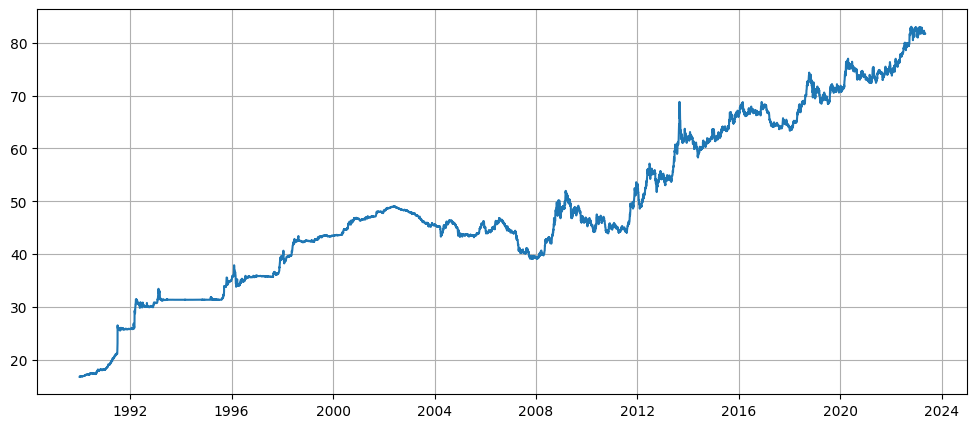

In [ ]:
# plot the series
plt.figure(figsize=(12,5))
plt.plot(variable_to_predict)
plt.grid(True)
plt.show

In [ ]:
# Augmented Dickey-Fuller test for staionarity
result = adfuller(variable_to_predict)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

# the series is not stationary since p-value > 0.05

ADF Statistic: -0.593269
p-value: 0.872496
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [ ]:
# get the differences of the observations for stationarity
variable_to_predict_diff1 = variable_to_predict.diff()
variable_to_predict_diff1
# first row should be dropped due to the NaN value

ds
1990-01-02      NaN
1990-01-03    0.090
1990-01-04    0.010
1990-01-05   -0.020
1990-01-08    0.000
              ...  
2023-05-01    0.050
2023-05-02   -0.020
2023-05-03    0.005
2023-05-04   -0.045
2023-05-05   -0.010
Name: y, Length: 8684, dtype: float64

In [ ]:
# drop the NaN row
variable_to_predict_diff1.dropna(inplace=True)
variable_to_predict_diff1
# now the series has one less row

ds
1990-01-03    0.090
1990-01-04    0.010
1990-01-05   -0.020
1990-01-08    0.000
1990-01-09    0.000
              ...  
2023-05-01    0.050
2023-05-02   -0.020
2023-05-03    0.005
2023-05-04   -0.045
2023-05-05   -0.010
Name: y, Length: 8683, dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

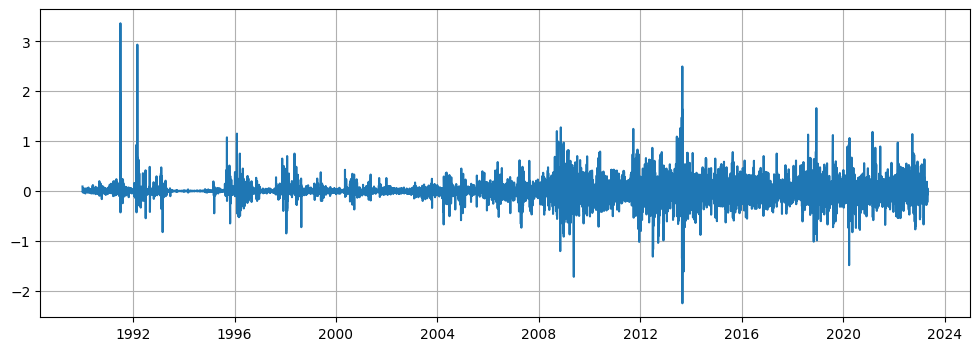

In [ ]:
# plot the series again to observe stationarity
plt.figure(figsize=(12,4))
plt.grid(True)
plt.plot(variable_to_predict_diff1)
plt.show

In [ ]:
# check again to see if the series gets stationary
result = adfuller(variable_to_predict_diff1, regression='ctt')
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.293107
p-value: 0.000000
Critical Values:
	1%: -4.372
	5%: -3.833
	10%: -3.554


(-0.05, 0.05)

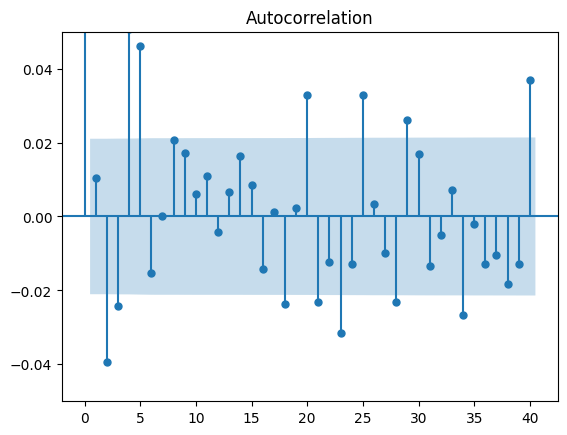

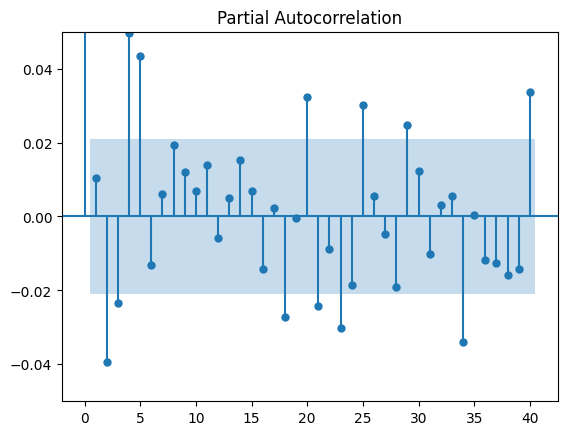

In [ ]:
# plot the autocorrelation and partial autocorrelation
# this tells us about the AR(p) and MA(q) values
acf = plot_acf(variable_to_predict_diff1)
plt.ylim(-0.05,0.05)
pacf = plot_pacf(variable_to_predict_diff1)
plt.ylim(-0.05,0.05)

Cross Validation using Rolling Split

In [ ]:
window_size = 30  # number of days in each split
stride = 7  # number of days to move forward for each split

train_data = []
test_data = []

predictions = []
test_data_list = []

# perform rolling window split and make predictions
for i in range(0, len(variable_to_predict) - window_size + 1, stride):
    train_data = variable_to_predict.iloc[i:i+window_size]
    test_data = variable_to_predict.iloc[i+window_size:i+window_size+stride]

    # fit the ARIMA model on the training data
    model = ARIMA(train_data, order=(1, 1, 1))
    results = model.fit()

    # make predictions on the test data
    forecast = results.forecast(steps=len(test_data))

    # append the forecasted values to the list
    predictions.extend(forecast)
    test_data_list.extend(test_data)



In [ ]:
#predictions = pd.Series(predictions, index=pd.Index(test_data_list))
print(predictions)

[16.929920641800962, 16.929918411516475, 16.929918348836512, 16.929918347074953, 16.929918347025446, 16.929918347024053, 16.929918347024014, 16.914824453805075, 16.911154128706677, 16.908551256310112, 16.906705385840556, 16.90539635594156, 16.904468035506984, 16.90380970155303, 16.976897440748907, 16.97562975188608, 16.975111781100388, 16.974900141049982, 16.97481366607461, 16.97477833286924, 16.974763895913387, 17.03000921282752, 17.03000923164128, 17.0300092316797, 17.030009231679777, 17.030009231679777, 17.030009231679777, 17.030009231679777, 17.1432426027288, 17.142518750741484, 17.142680337510928, 17.142644266208347, 17.142652318469523, 17.14265052094891, 17.14265092221264, 17.146817437045954, 17.146915432390653, 17.1469124149837, 17.14691250789367, 17.146912505032848, 17.146912505120937, 17.146912505118227, 17.236945279181555, 17.23660192580859, 17.236618900149814, 17.23661806099027, 17.236618102475752, 17.236618100424838, 17.23661810052623, 17.268312558512605, 17.268778082831954

In [ ]:
#test_data = pd.Series(test_data_list, index=pd.Index(test_data_list))
print(test_data_list)

[16.88, 16.89, 16.92, 16.92, 16.91, 16.91, 16.92, 16.94, 16.96, 16.96, 16.96, 16.96, 16.98, 16.98, 16.97, 16.97, 16.97, 16.97, 17.03, 17.03, 17.03, 17.03, 17.05, 17.02, 17.02, 17.08, 17.12, 17.14, 17.11, 17.11, 17.11, 17.18, 17.18, 17.17, 17.15, 17.14, 17.16, 17.18, 17.19, 17.19, 17.19, 17.23, 17.23, 17.26, 17.28, 17.24, 17.24, 17.27, 17.27, 17.27, 17.3, 17.3, 17.29, 17.28, 17.28, 17.28, 17.25, 17.2, 17.23, 17.27, 17.24, 17.23, 17.21, 17.18, 17.22, 17.22, 17.22, 17.21, 17.21, 17.19, 17.3, 17.348, 17.378, 17.403, 17.516, 17.464, 17.447, 17.44, 17.45, 17.501, 17.463, 17.435, 17.402, 17.458, 17.449, 17.444, 17.426, 17.431, 17.435, 17.447, 17.44, 17.441, 17.463, 17.489, 17.489, 17.472, 17.472, 17.447, 17.45, 17.387, 17.374, 17.399, 17.483, 17.457, 17.458, 17.441, 17.417, 17.429, 17.447, 17.46, 17.447, 17.46, 17.466, 17.422, 17.39, 17.393, 17.382, 17.382, 17.385, 17.325, 17.345, 17.369, 17.394, 17.413, 17.363, 17.36, 17.36, 17.318, 17.313, 17.387, 17.357, 17.322, 17.352, 17.38, 17.387, 17.4

In [ ]:
# evaluate the predictions against the actual values
mae = mean_absolute_error(test_data_list, predictions)
mse = mean_squared_error(test_data_list, predictions)
rmse = np.sqrt(mse)
print("MAE Value: ", mae)
print("RMSE Value: ", rmse)

MAE Value:  0.24539231982014523
RMSE Value:  0.43254912093061554


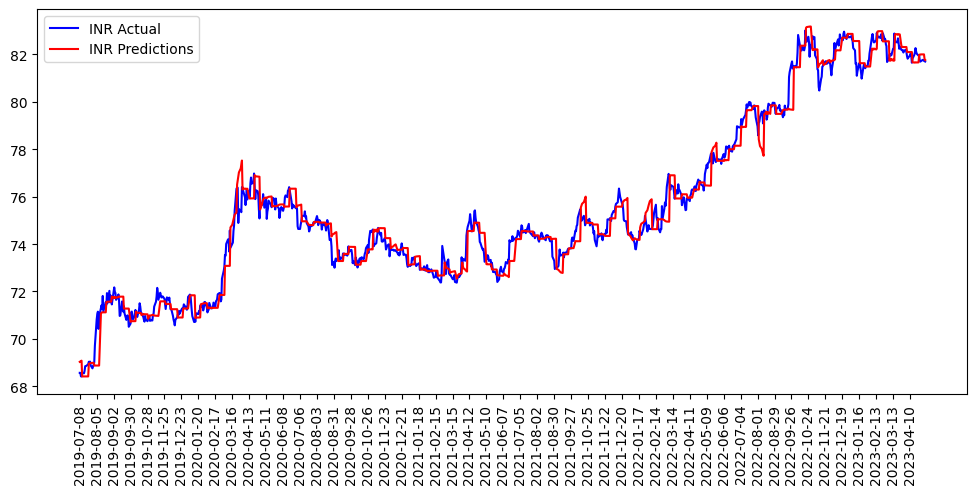

In [ ]:
# plot the actual test and predicted values
plt.figure(figsize=(12,5))
plt.plot(variable_to_predict.iloc[-1000:].index, test_data_list[-1000:], color='blue')
plt.plot(variable_to_predict.iloc[-1000:].index, predictions[-1000:], color='red')
plt.legend(('INR Actual', 'INR Predictions'))
plt.xticks(variable_to_predict.iloc[-1000::20].index, rotation = 90)
plt.show()

Future out-of-sample predictions

In [ ]:
def future_rate(sdate, edate):
    sdate = pd.to_datetime(sdate)
    edate = pd.to_datetime(edate)
    nd = abs(sdate-edate)
    nd = nd.days
    pred = results.forecast(steps=nd, frequency='d')
    print(pred)
    return pred

In [ ]:
pred = future_rate('2023-05-03', '2023-06-01')

2023-05-04    81.789292
2023-05-05    81.764000
2023-05-08    81.782654
2023-05-09    81.768896
2023-05-10    81.779043
2023-05-11    81.771559
2023-05-12    81.777079
2023-05-15    81.773008
2023-05-16    81.776011
2023-05-17    81.773796
2023-05-18    81.775429
2023-05-19    81.774225
2023-05-22    81.775113
2023-05-23    81.774458
2023-05-24    81.774941
2023-05-25    81.774585
2023-05-26    81.774848
2023-05-29    81.774654
2023-05-30    81.774797
2023-05-31    81.774691
2023-06-01    81.774769
2023-06-02    81.774712
2023-06-05    81.774754
2023-06-06    81.774723
2023-06-07    81.774746
2023-06-08    81.774729
2023-06-09    81.774741
2023-06-12    81.774732
2023-06-13    81.774739
Freq: B, Name: predicted_mean, dtype: float64


In [ ]:
pred.iloc[-1]

81.77473893740206